## **Time-based Analysis**

Welcome to this Colab where you will get a profound analysis of the fluctuation of different variables throughout a range of time. Here, you can see how the pandemic has progressed, how increasingly devastated it is, and how countries responded to the pandemic.

To start, we imported a great number of useful libraries to assist us with data processing, calculating and visualization.

In [ ]:
!pip install geopandas
!pip install pycountry
!pip install mapclassify

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from statistics import mean
import geopandas
import pycountry 
from statsmodels.tsa.seasonal import seasonal_decompose
import sys
from scipy.signal import find_peaks
import statistics
from matplotlib.colors import LinearSegmentedColormap
from geopandas.plotting import plot_polygon_collection
import mapclassify
import seaborn as sns

     |████████████████████████████████| 1.0MB 8.7MB/s 
     |████████████████████████████████| 6.6MB 25.0MB/s 
     |████████████████████████████████| 15.4MB 195kB/s 
     |████████████████████████████████| 10.1MB 6.0MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=91562b03d350631864e7aef89d405bc390d6d6ebbfa19db7649e0f756e7b643a
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


## The time period

The default time period mentioned in the assignment as YYYY-MM-DD. This period will be divided to two periods, 01/07/2020 to 31/12/2020 and 01/01/2021 to 31/5/2021 throughout our calculations.

In [ ]:
start_date = '2020-07-01'
end_date = '2021-05-31'

## Getting data from GitHub

For this colab, we used two files from the same source, OWID. The data has been processed to suit our deepest and darkest desires.

In [ ]:
data_covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv", parse_dates=['date'], index_col='date')
data_vaccine = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv", parse_dates=['date'], index_col='date')
data_vaccinations_by_age_group = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations-by-age-group.csv", parse_dates=['date'])

data_countries = data_covid[~data_covid["iso_code"].str.contains("OWID")].loc[start_date:end_date]
data_continent_daily_new_cases = data_covid[["continent", "location", "new_cases"]].loc[start_date:end_date].dropna()
data_world = data_covid[data_covid["location"] == "World"]
data_vaccinations_by_age_group = data_vaccinations_by_age_group[(data_vaccinations_by_age_group["date"] <= end_date) & (data_vaccinations_by_age_group["date"] >= "2021-05-28")]

data_daily_vaccinations = data_vaccine[["location", "daily_vaccinations", "people_vaccinated", "people_fully_vaccinated", "total_vaccinations_per_hundred", "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred"]].loc[start_date:end_date].dropna()
data_world_daily_vaccinations = data_daily_vaccinations[data_daily_vaccinations["location"] == "World"]

## World daily new cases and daily new vaccinations

We start the analysis with a graph of daily new cases and daily new vaccinations of the world. This give us a general grasp of the situation.


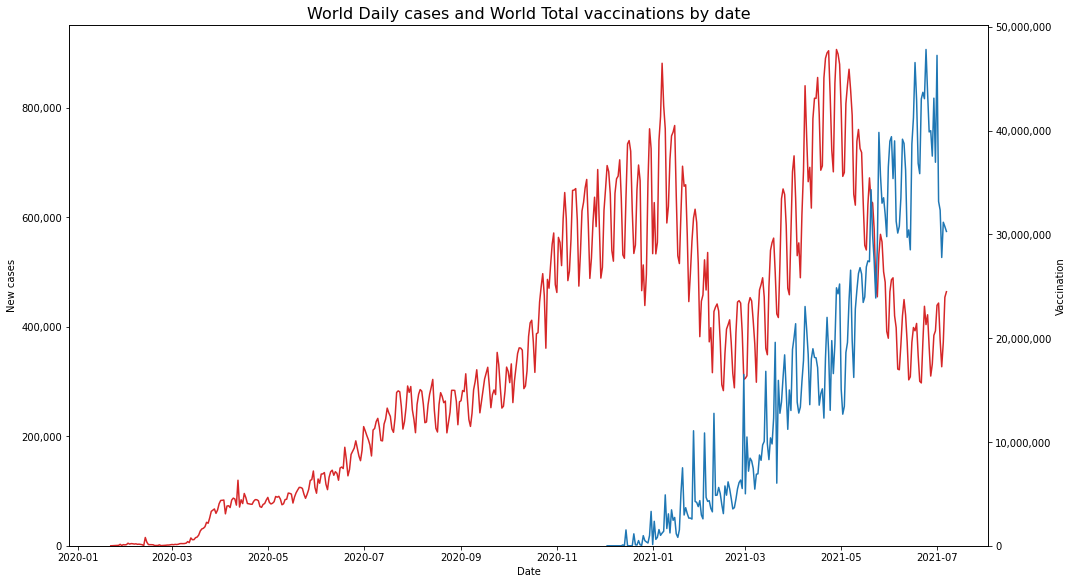

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.set_xlabel('Date')
ax1.set_ylabel('New cases')
ax1.plot(data_world["new_cases"], color='tab:red')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_ylabel('Vaccination')
ax2.plot(data_world["new_vaccinations"], color='tab:blue')
ax2.tick_params(axis='y')

ax1.set_ylim(ymin=0)
ax2.set_ylim(ymin=0)
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.tight_layout()
plt.title("World Daily cases and World Total vaccinations by date", fontsize=16)
plt.show()

## Inspecting the vaccination progress of an individual country

The following code cell helps us take a quick glance at a country's vaccination progress, represented as a bar chart. Specifically, we will see how many percent of the population has received at least one dose of vaccine, and has been fully vaccinated. 

Some countries - such as Vietnam - will not yield a good chart due to its lack of data.

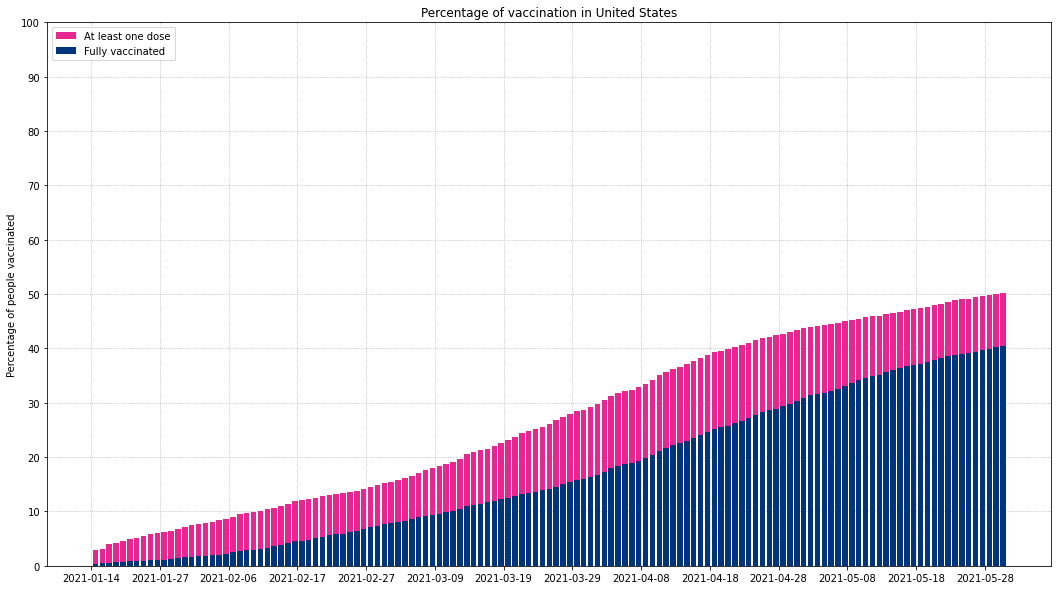

In [ ]:
countries_total_cases = data_covid[["continent", "location", "total_cases", "total_cases_per_million"]].loc["2021-06-01"].dropna()
countries_total_vaccine = data_vaccine[["location", "total_vaccinations", "total_vaccinations_per_hundred"]].loc["2021-06-01"].dropna()

data_total_countries = countries_total_cases.merge(countries_total_vaccine, how = "inner")
data_total_countries = data_total_countries[data_total_countries["location"].notna()]

#country_name = input("Choose the country you want to inspect: ")
country_name = "United States" # Temporary

data_daily_new_cases_single_country = data_continent_daily_new_cases[data_continent_daily_new_cases["location"] == country_name]
data_daily_vaccinations_single_country = data_daily_vaccinations[data_daily_vaccinations["location"] == country_name].dropna()

temp = data_daily_new_cases_single_country.merge(data_daily_vaccinations_single_country, how = "inner", left_index=True, right_index=True)

a = temp["people_fully_vaccinated_per_hundred"]
b = temp["people_vaccinated_per_hundred"]

ind = np.arange(len(a))
ind2 = np.arange(0, len(a), 10)

width = 0.65

date_interval = a[ind2]
f, ax = plt.subplots(figsize=(18,10))
ax1 = ax.bar(ind+width, b, .8, color='#e62790', label = "At least one dose", zorder=5)
ax2 = ax.bar(ind+width, a, .8, color='#00347b', label = "Fully vaccinated", zorder=5)

plt.ylim(0, 100)
ax.axhline(0, color='grey', linewidth=0.1)
ax.set_ylabel('Date')
ax.set_ylabel('Percentage of people vaccinated')
ax.set_title("Percentage of vaccination in " + country_name)
ax.set_xticks(ind2)
plt.grid(linestyle=':', zorder=0)

ax.set_xticklabels(date_interval.index.date)
ax.set_yticks(np.linspace(0, 110, num = 11, endpoint=False))
ax.legend(loc = "upper left")

plt.show()

## Deeper analysis

Next, we will divide the countries into categories by different factors. Inspecting these factors required us to represent the data in a comprehensible and accessible manner. The formatted_print() function allows us to do just that.

In [ ]:
def formatted_print(_list):
  pretty = 75
  temp = 0

  country_names = []
  for country in _list:
    country_names.append(pycountry.countries.get(alpha_3=country).name)
  country_names.sort()

  for country in country_names:
    if (temp >= pretty):
      temp = 0
      print(country + ",")
    else:
      print(country + ",", end = " ")
    temp += len(country)
  print() 
  print() 

## The four common trends in daily new cases

Most countries in out dataset began their vaccination campaign at the start of 2021. To get a general grasp of the situation, we chose China (the first country identified the disease) and three countries with the highest deaths and confirmed cases : US, India and Brazil. The're also the four countries with the highest vaccinations.

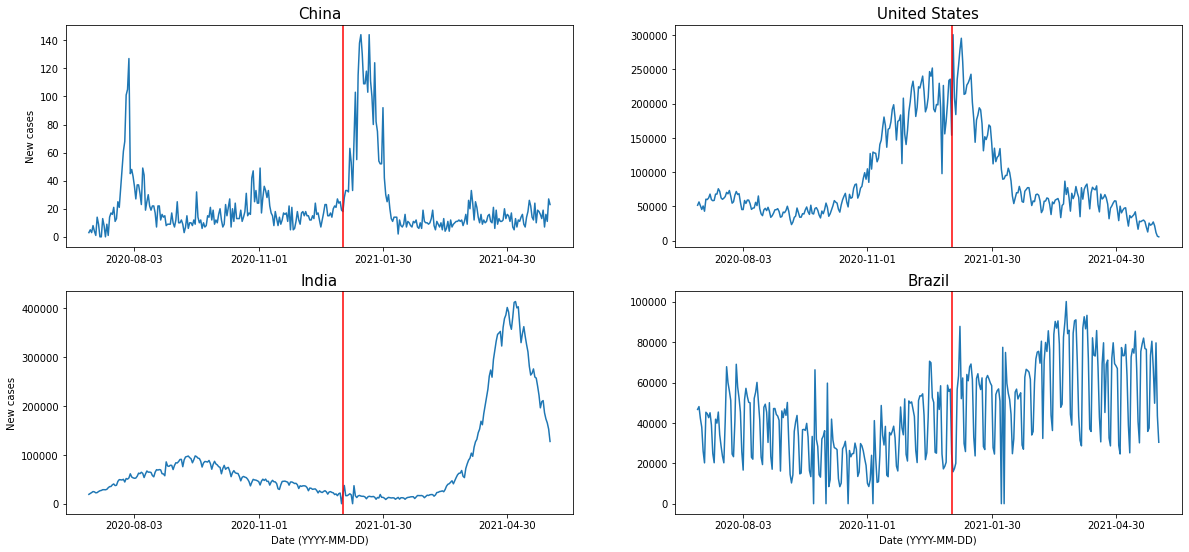

In [ ]:
loc = matplotlib.ticker.MultipleLocator(base=90) 
ax.xaxis.set_major_locator(loc)

fig, axs = plt.subplots(2, 2, figsize = (20, 9))

inspecting_countries = [["China", "United States"], ["India", "Brazil"]]

for row in range(2):
  for col in range(2):
    axs[row, col].plot(data_countries[data_countries["location"] == inspecting_countries[row][col]]["new_cases"])
    axs[row, col].axes.get_xaxis().get_label().set_visible(row == 1)
    axs[row, col].axes.get_yaxis().get_label().set_visible(col == 0)
    axs[row, col].set_title(inspecting_countries[row][col], fontsize = 15)
    data_total_cases_single_country = data_covid[data_covid["location"] == inspecting_countries[row][col]]["new_cases"].loc[start_date:end_date].dropna()
    axs[row, col].axvline(pd.Timestamp('2021-01-01'),color='r')

for ax in axs.flat:
    ax.set(xlabel='Date (YYYY-MM-DD)', ylabel='New cases')
    ax.xaxis.set_major_locator(loc)

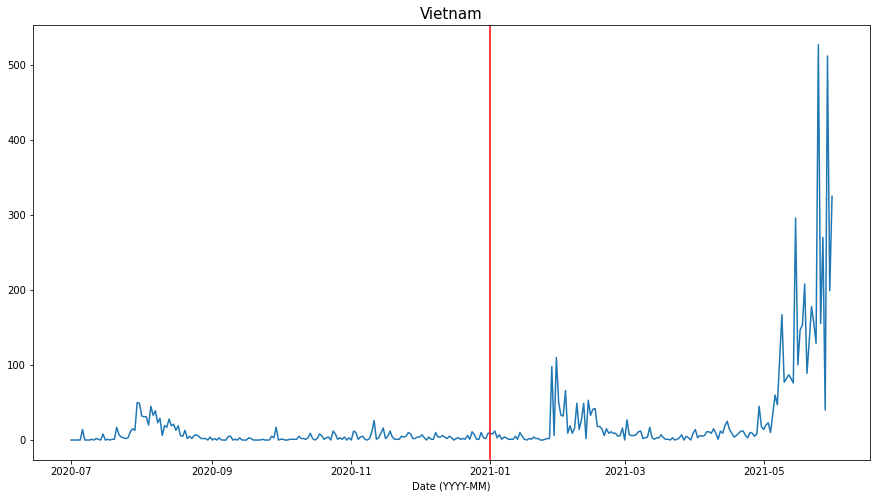

In [ ]:
fig, axs = plt.subplots(figsize = (15, 8))
axs.plot(data_countries[data_countries["location"] == "Vietnam"]["new_cases"])
axs.axes.get_xaxis().get_label().set_visible(row == 1)
axs.axes.get_yaxis().get_label().set_visible(col == 0)
axs.set_title("Vietnam", fontsize = 15)
data_total_cases_single_country = data_covid[data_covid["location"] == "Vietnam"]["new_cases"].loc[start_date:end_date].dropna()
axs.axvline(pd.Timestamp('2021-01-01'),color='r')
axs.set(xlabel='Date (YYYY-MM)', ylabel='New cases')
plt.show()

## The general trends in daily new cases

Having spotted the four common trends in daily new cases, we've divided all countries into four groups. We've used linear regression to identify the trend before and after vaccination.

In [ ]:
new_cases_up_up = []
new_cases_down_down = []
new_cases_up_down = []
new_cases_down_up = []

for country in data_countries["iso_code"].unique():
  data_total_cases_single_country = data_countries[data_countries["iso_code"] == country]["new_cases"].loc[start_date:end_date].dropna()

  first = data_total_cases_single_country.loc[start_date:"2020-12-31"]
  second = data_total_cases_single_country.loc["2021-01-01":end_date]

  try:
    delta1 = (first.index - first.index[0])
    x1 = delta1.days
    res1 = linregress(x1, first)

    delta2 = (second.index - second.index[0])
    x2 = delta2.days
    res2 = linregress(x2, second)
  except:
    continue

  if (res1.slope > 0):
    if (res2.slope > 0):
      new_cases_up_up.append(country)
    else:
      new_cases_up_down.append(country)
  else:
    if (res2.slope > 0):
      new_cases_down_up.append(country)
    else:
      new_cases_down_down.append(country)

Using formatted_print(), we can take a look at the results:

In [ ]:
print("Total: " + str(len(new_cases_up_up + new_cases_up_down + new_cases_down_up + new_cases_down_down)))
print() 
print("Increase then increase: " + str(len(new_cases_up_up)))
formatted_print(new_cases_up_up)
print("Increase then decrease: " + str(len(new_cases_up_down)))
formatted_print(new_cases_up_down)
print("Decrease then increase: " + str(len(new_cases_down_up)))
formatted_print(new_cases_down_up)
print("Decrease then decrease: " + str(len(new_cases_down_down)))
formatted_print(new_cases_down_down)

Total: 189

Increase then increase: 51
Afghanistan, Angola, Argentina, Armenia, Azerbaijan, Belgium, Bhutan, Bosnia and Herzegovina, Botswana,
Bulgaria, Cabo Verde, Canada, Colombia, Costa Rica, Croatia, Cuba, Cyprus, Fiji, France, Georgia,
Greece, Guyana, Hungary, Iran, Islamic Republic of, Japan, Jordan, Kenya, Korea, Republic of, Lao People's Democratic Republic,
Malaysia, Mali, Mauritius, Mongolia, Nepal, Netherlands, Norway,
Pakistan, Palestine, State of, Paraguay, Saint Kitts and Nevis, Seychelles, Somalia, Sri Lanka,
Syrian Arab Republic, Taiwan, Province of China, Thailand, Timor-Leste, Turkey, Uganda,
Ukraine, Uruguay, 

Increase then decrease: 73
Albania, Algeria, Andorra, Antigua and Barbuda, Austria, Barbados, Belarus, Belize, Brunei Darussalam, Burkina Faso,
Chad, Comoros, Congo, The Democratic Republic of the, Czechia, Denmark, Dominica, Eritrea,
Estonia, Eswatini, Finland, Germany, Grenada, Holy See (Vatican City State), Hong Kong, Iceland,
Indonesia, Ireland, Israel, It

We've also provided a world map for better visualization:

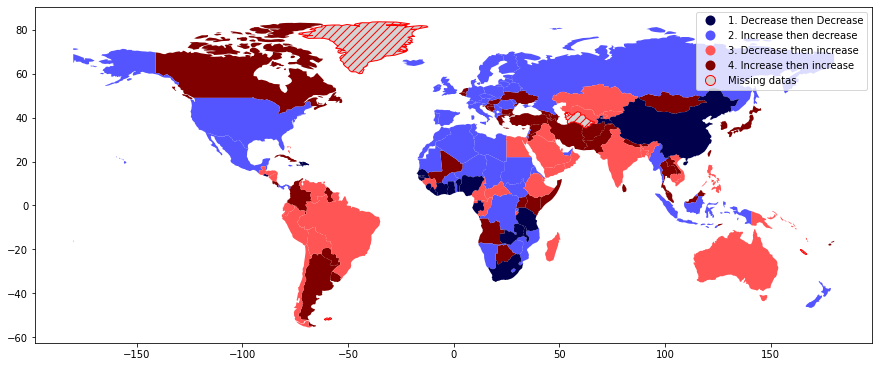

In [ ]:
data_two_periods_raw = []
nan_country_list = np.setdiff1d(data_covid["iso_code"].unique(), 
                                np.array(new_cases_up_up + new_cases_down_down + new_cases_up_down + new_cases_down_up))

for country in new_cases_up_up:
  data_two_periods_raw.append([str(country), '4. Increase then increase'])
for country in new_cases_up_down:
  data_two_periods_raw.append([str(country), '2. Increase then decrease'])
for country in new_cases_down_up:
  data_two_periods_raw.append([str(country), '3. Decrease then increase'])
for country in new_cases_down_down:
  data_two_periods_raw.append([str(country), '1. Decrease then Decrease'])
for country in nan_country_list:
  data_two_periods_raw.append([str(country), ])
data_two_periods = pd.DataFrame(data_two_periods_raw, columns= ["Country", "Trend"])

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = data_two_periods.merge(world, left_on=  "Country", right_on= "iso_a3")
world = geopandas.GeoDataFrame(world)
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['trend'] = world.Trend
world.plot(column="trend", legend=True, cmap="seismic", figsize=(15, 10), missing_kwds={
    "color": "lightgrey",
    "edgecolor": "red",
    "hatch": "///",
    "label": "Missing datas",
    },
);

## Trend in May 2021

The last month of our analysis marks the rise of the new Delta variant, so we also provided an analysis of this month.

In [ ]:
new_cases_up_down_and_down_down = new_cases_up_down + new_cases_down_down + new_cases_up_up + new_cases_down_up
new_cases_last_month_up = []
new_cases_last_month_down = []

for country in new_cases_up_down_and_down_down:
  data_total_cases_single_country = data_covid[data_covid["iso_code"] == country]["new_cases"].loc[start_date:end_date].dropna()

  first = data_total_cases_single_country.loc["2021-05-01":end_date]

  delta1 = (first.index - first.index[0])
  x1 = delta1.days
  res1 = linregress(x1, first)

  if (res1.slope > 1):
    new_cases_last_month_up.append(country)
  else:
    new_cases_last_month_down.append(country)

Below is a list of trends in May.

In [ ]:
print("Total: " + str(len(new_cases_up_down_and_down_down)))
print() 
print("Increase: " + str(len(new_cases_last_month_up)))
formatted_print(new_cases_last_month_up)
print("Decrease: " + str(len(new_cases_last_month_down)))
formatted_print(new_cases_last_month_down)

Total: 189

Increase: 48
Afghanistan, Algeria, Angola, Argentina, Bahrain, Belarus, Bolivia, Plurinational State of, Botswana,
Brazil, Chile, Colombia, Congo, The Democratic Republic of the, Costa Rica, Cuba, Dominican Republic,
El Salvador, Equatorial Guinea, Guatemala, Haiti, Indonesia, Libya, Malaysia, Maldives,
Mauritania, Myanmar, Namibia, Nigeria, Oman, Panama, Paraguay, Portugal, Russian Federation, Saudi Arabia,
South Africa, Sri Lanka, Suriname, Taiwan, Province of China, Thailand, Timor-Leste, Trinidad and Tobago,
Tunisia, Uganda, United Arab Emirates, United Kingdom, Uruguay, Venezuela, Bolivarian Republic of, Viet Nam,
Zambia, 

Decrease: 141
Albania, Andorra, Antigua and Barbuda, Armenia, Australia, Austria, Azerbaijan, Bahamas, Bangladesh, Barbados,
Belgium, Belize, Benin, Bhutan, Bosnia and Herzegovina, Brunei Darussalam, Bulgaria, Burkina Faso,
Burundi, Cabo Verde, Cambodia, Cameroon, Canada, Central African Republic, Chad,
China, Comoros, Congo, Croatia, Cyprus, Czechi

We also provided a map for May.

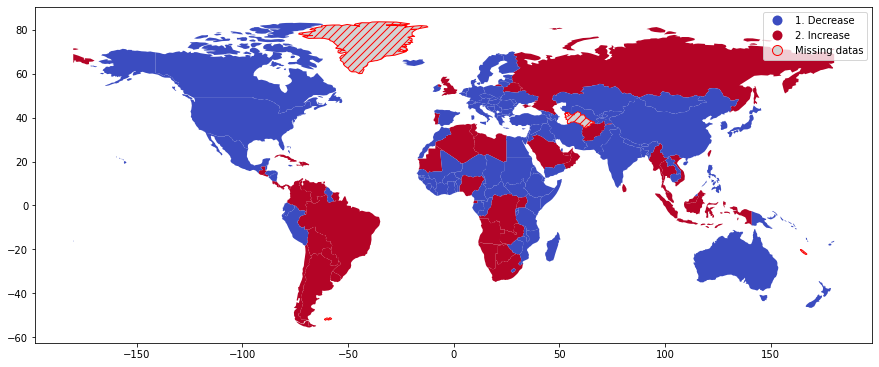

In [ ]:
data_two_periods_raw = []
nan_country_list = np.setdiff1d(data_covid["iso_code"].unique(), np.array(new_cases_up_down_and_down_down))

for country in new_cases_last_month_up:
  data_two_periods_raw.append([str(country), "2. Increase"])
for country in new_cases_last_month_down:
  data_two_periods_raw.append([str(country), "1. Decrease"])
for country in nan_country_list:
  data_two_periods_raw.append([str(country), ])

data_two_periods = pd.DataFrame(data_two_periods_raw, columns= ["Country", "Trend"])

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = data_two_periods.merge(world, left_on=  "Country", right_on= "iso_a3")
world = geopandas.GeoDataFrame(world)
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['trend'] = world.Trend
world.plot(column="trend", legend=True, cmap="coolwarm", figsize=(15, 10), missing_kwds={
    "color": "lightgrey",
    "edgecolor": "red",
    "hatch": "///",
    "label": "Missing datas",
    },
);


## The general trends in daily new deaths

Deaths plays an important part in predicting and analyzing the pandemic, so we also study this variable.

*******************************************************************************************
****************************** DEATH TRENDS FROM 01-01-2021 *******************************
*******************************************************************************************
Total: 189

Increase: 83
Afghanistan, Algeria, Angola, Antigua and Barbuda, Argentina, Armenia, Australia, Azerbaijan, Bahamas,
Bahrain, Bangladesh, Belarus, Bolivia, Plurinational State of, Bosnia and Herzegovina, Botswana,
Brazil, Bulgaria, Cabo Verde, Cameroon, Central African Republic, Chile, Colombia, Costa Rica,
Croatia, Cuba, Côte d'Ivoire, Djibouti, Ecuador, Equatorial Guinea, Ethiopia, Fiji, Gabon,
Greece, Guinea, Guinea-Bissau, Guyana, Haiti, Honduras, Hungary, India, Iran, Islamic Republic of, Iraq,
Jamaica, Jordan, Kenya, Kuwait, Kyrgyzstan, Madagascar, Malaysia, Maldives, Mali, Mauritius, Mongolia,
Namibia, Nepal, North Macedonia, Oman, Pakistan, Papua New Guinea, Paraguay, Peru, Philippines,
Poland, Q

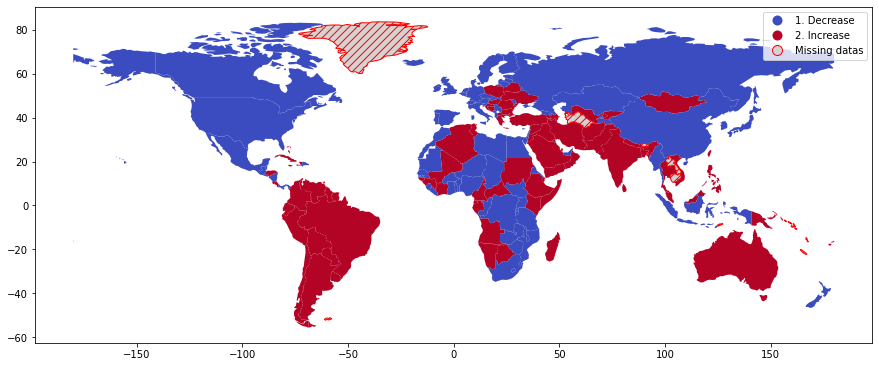

In [ ]:
new_deaths_up_up = []
new_deaths_down_down = []
new_deaths_up_down = []
new_deaths_down_up = []

for country in data_countries["iso_code"].unique():
  data_total_cases_single_country = data_countries[data_countries["iso_code"] == country]["new_deaths"].loc[start_date:end_date].dropna()

  first = data_total_cases_single_country.loc[start_date:"2020-12-31"]
  second = data_total_cases_single_country.loc["2021-01-01":end_date]

  try:
    delta1 = (first.index - first.index[0])
    x1 = delta1.days
    res1 = linregress(x1, first)

    delta2 = (second.index - second.index[0])
    x2 = delta2.days
    res2 = linregress(x2, second)
  except:
    continue

  if (res1.slope > 0):
    if (res2.slope > 0):
      new_deaths_up_up.append(country)
    else:
      new_deaths_up_down.append(country)
  else:
    if (res2.slope > 0):
      new_deaths_down_up.append(country)
    else:
      new_deaths_down_down.append(country)

new_deaths_second_period_up = new_deaths_up_up + new_deaths_down_up
new_deaths_second_period_down = new_deaths_up_down + new_deaths_down_down
nan_country_list = np.setdiff1d(data_covid["iso_code"].unique(), 
                                np.array(new_deaths_second_period_up + new_deaths_second_period_down))
data_two_periods_raw = []

for country in new_deaths_second_period_up:
  data_two_periods_raw.append([str(country), "2. Increase"])
for country in new_deaths_second_period_down:
  data_two_periods_raw.append([str(country), "1. Decrease"])
for country in nan_country_list:
  data_two_periods_raw.append([str(country), ])

data_two_periods = pd.DataFrame(data_two_periods_raw, columns= ["Country", "Trend"])

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = data_two_periods.merge(world, left_on=  "Country", right_on= "iso_a3")
world = geopandas.GeoDataFrame(world)
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['trend'] = world.Trend
world.plot(column="trend", legend=True, cmap="coolwarm", figsize=(15, 10), missing_kwds={
    "color": "lightgrey",
    "edgecolor": "red",
    "hatch": "///",
    "label": "Missing datas",
    },
);

print("*******************************************************************************************")
print("****************************** DEATH TRENDS FROM 01-01-2021 *******************************")
print("*******************************************************************************************")

print("Total: " + str(len(new_cases_up_down_and_down_down)))
print() 
print("Increase: " + str(len(new_deaths_second_period_up)))
formatted_print(new_deaths_up_up + new_deaths_down_up)
print("Decrease: " + str(len(new_deaths_second_period_down)))
formatted_print(new_deaths_down_down + new_deaths_up_down)

After analyzing the data with all countries, we've decided to choose some countries to represent each group's characteristics

## Countries with daily new cases increased in both period

These are the countries with the slope of daily new cases point upwards in both periods. We've chosen Pakistan, Japan, Thailand, South Korea, Canada, Malaysia as the countries for this group. Graphs of those countries' daily new cases has also been provided below.

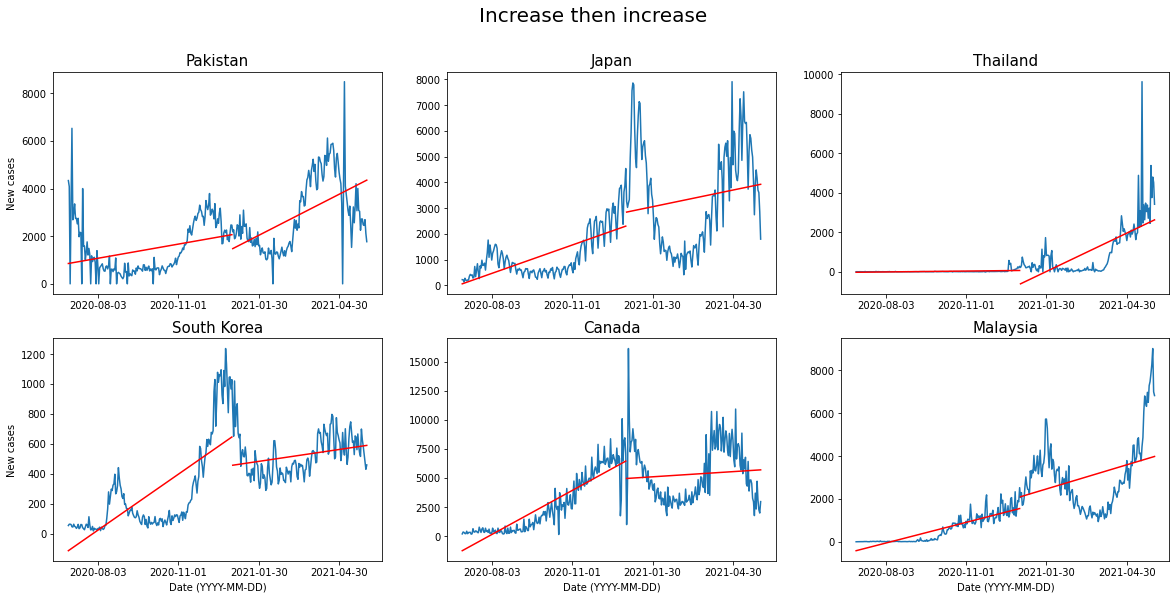

In [ ]:
loc = matplotlib.ticker.MultipleLocator(base=90) 
ax.xaxis.set_major_locator(loc)

fig, axs = plt.subplots(2, 3, figsize = (20, 9))
fig.suptitle('Increase then increase', fontsize = 20)

inspecting_countries = [["Pakistan", "Japan", "Thailand"], ["South Korea", "Canada", "Malaysia"]]

for row in range(2):
  for col in range(3):
    axs[row, col].plot(data_countries[data_countries["location"] == inspecting_countries[row][col]]["new_cases"])
    axs[row, col].axes.get_xaxis().get_label().set_visible(row == 1)
    axs[row, col].axes.get_yaxis().get_label().set_visible(col == 0)
    axs[row, col].set_title(inspecting_countries[row][col], fontsize = 15)
    data_total_cases_single_country = data_covid[data_covid["location"] == inspecting_countries[row][col]]["new_cases"].loc[start_date:end_date].dropna()

    first = data_total_cases_single_country.loc[start_date:"2020-12-31"]
    x1 = (first.index - first.index[0]).days
    res1 = linregress(x1, first)

    second = data_total_cases_single_country.loc["2021-01-01":end_date]
    x2 = (second.index - second.index[0]).days
    res2 = linregress(x2, second)

    axs[row, col].plot(first.index, res1.intercept + res1.slope*x1, 'r')
    axs[row, col].plot(second.index, res2.intercept + res2.slope*x2, 'r')

for ax in axs.flat:
    ax.set(xlabel='Date (YYYY-MM-DD)', ylabel='New cases')
    ax.xaxis.set_major_locator(loc)

## Countries with daily new cases increased in the first period, but decreased in the second period

These are the countries with the trend of daily new cases went down during the first period, but went up in the second period. We've chosen United States, Indonesia, Russia, Germany, United Kingdom, United Arab Emirates for this group. Six graphs of those countries has been presented.

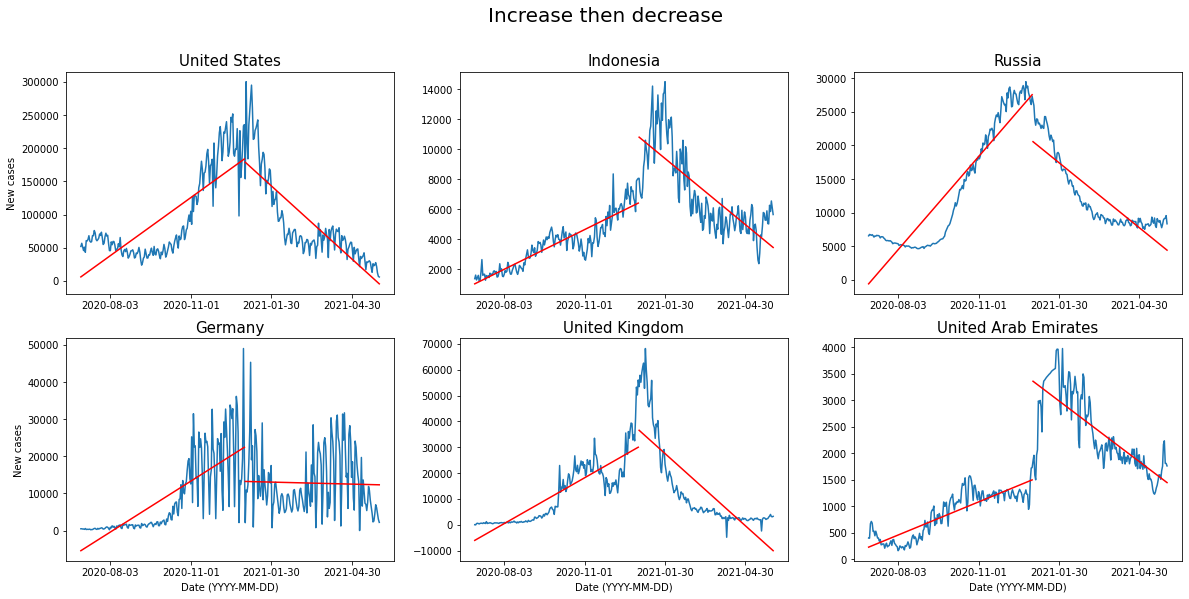

In [ ]:
loc = matplotlib.ticker.MultipleLocator(base=90) 
ax.xaxis.set_major_locator(loc)

fig, axs = plt.subplots(2, 3, figsize = (20, 9))
fig.suptitle('Increase then decrease', fontsize = 20)

inspecting_countries = [["United States", "Indonesia", "Russia"], ["Germany", "United Kingdom", "United Arab Emirates"]]

for row in range(2):
  for col in range(3):
    axs[row, col].plot(data_countries[data_countries["location"] == inspecting_countries[row][col]]["new_cases"])
    axs[row, col].axes.get_xaxis().get_label().set_visible(row == 1)
    axs[row, col].axes.get_yaxis().get_label().set_visible(col == 0)
    axs[row, col].set_title(inspecting_countries[row][col], fontsize = 15)
    data_total_cases_single_country = data_covid[data_covid["location"] == inspecting_countries[row][col]]["new_cases"].loc[start_date:end_date].dropna()

    first = data_total_cases_single_country.loc[start_date:"2020-12-31"]
    x1 = (first.index - first.index[0]).days
    res1 = linregress(x1, first)

    second = data_total_cases_single_country.loc["2021-01-01":end_date]
    x2 = (second.index - second.index[0]).days
    res2 = linregress(x2, second)

    axs[row, col].plot(first.index, res1.intercept + res1.slope*x1, 'r')
    axs[row, col].plot(second.index, res2.intercept + res2.slope*x2, 'r')

for ax in axs.flat:
    ax.set(xlabel='Date (YYYY-MM-DD)', ylabel='New cases')
    ax.xaxis.set_major_locator(loc)

## Countries with daily new cases decreased in the first period, but increased in the second period

These are the countries with their daily new cases having a tendency to decrease in the first period, but then increased in the second period. India, Brazil, Philippines, Vietnam, Cambodia, Singapore are the countries chosen for this group. Graphs of those countries can be found below.

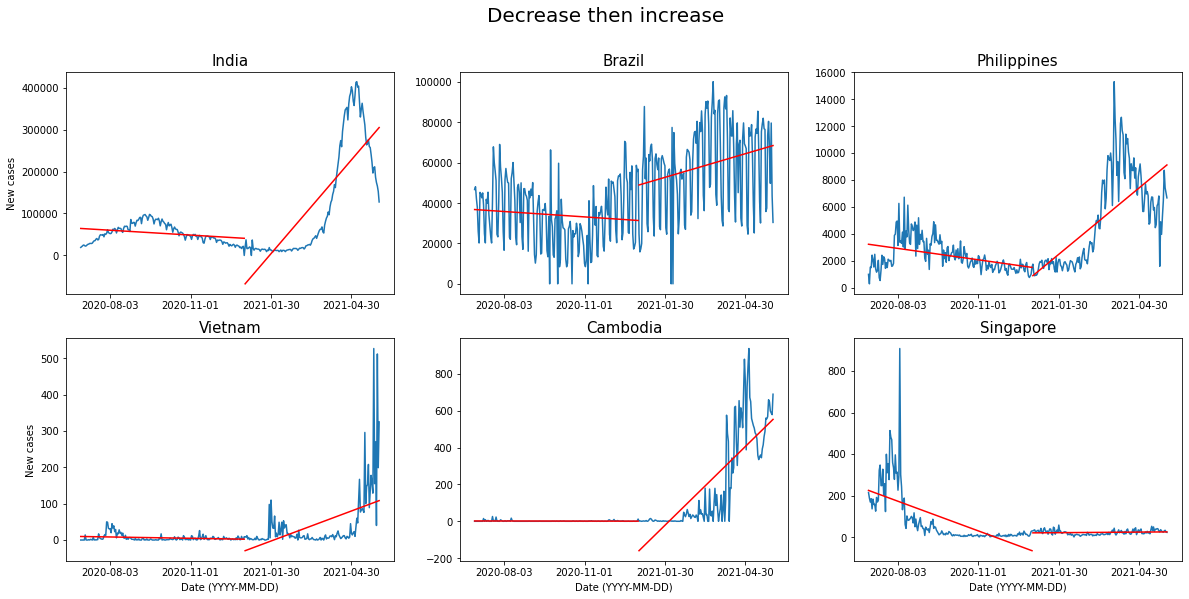

In [ ]:
loc = matplotlib.ticker.MultipleLocator(base=90) 
ax.xaxis.set_major_locator(loc)

fig, axs = plt.subplots(2, 3, figsize = (20, 9))
fig.suptitle('Decrease then increase', fontsize = 20)

inspecting_countries = [["India", "Brazil", "Philippines"], ["Vietnam", "Cambodia", "Singapore"]]

for row in range(2):
  for col in range(3):
    axs[row, col].plot(data_countries[data_countries["location"] == inspecting_countries[row][col]]["new_cases"])
    axs[row, col].axes.get_xaxis().get_label().set_visible(row == 1)
    axs[row, col].axes.get_yaxis().get_label().set_visible(col == 0)
    axs[row, col].set_title(inspecting_countries[row][col], fontsize = 15)
    data_total_cases_single_country = data_covid[data_covid["location"] == inspecting_countries[row][col]]["new_cases"].loc[start_date:end_date].dropna()

    first = data_total_cases_single_country.loc[start_date:"2020-12-31"]
    x1 = (first.index - first.index[0]).days
    res1 = linregress(x1, first)

    second = data_total_cases_single_country.loc["2021-01-01":end_date]
    x2 = (second.index - second.index[0]).days
    res2 = linregress(x2, second)

    axs[row, col].plot(first.index, res1.intercept + res1.slope*x1, 'r')
    axs[row, col].plot(second.index, res2.intercept + res2.slope*x2, 'r')

for ax in axs.flat:
    ax.set(xlabel='Date (YYYY-MM-DD)', ylabel='New cases')
    ax.xaxis.set_major_locator(loc)

## Countries with daily new cases increased in both period

These are the countries with their daily new cases generally decreased in both periods. We've chosen China, Nigeria and South Africa as the representers of said group. You can inspect those countries' graphs down below.

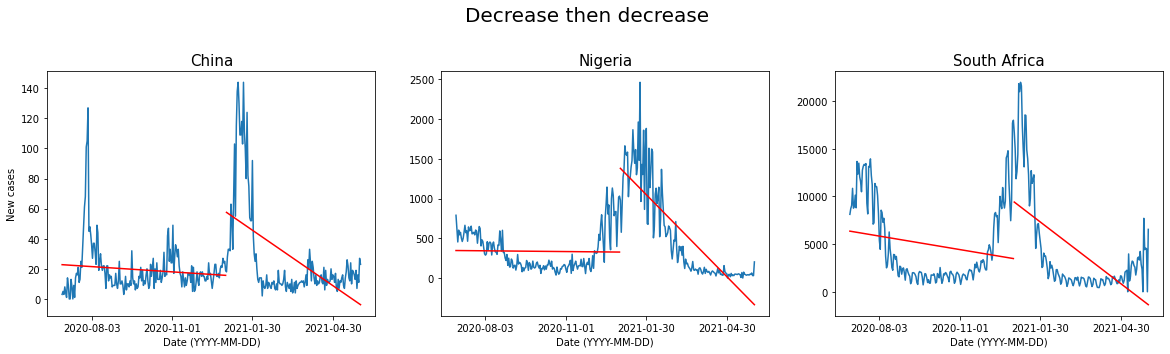

In [ ]:
loc = matplotlib.ticker.MultipleLocator(base=90) 
ax.xaxis.set_major_locator(loc)

fig, axs = plt.subplots(1, 3, figsize = (20, 4.5))
fig.suptitle('Decrease then decrease', fontsize = 20, y=1.08)

inspecting_countries = ["China", "Nigeria", "South Africa"]

for col in range(3):
  axs[col].plot(data_countries[data_countries["location"] == inspecting_countries[col]]["new_cases"])
  axs[col].axes.get_yaxis().get_label().set_visible(col == 0)
  axs[col].set_title(inspecting_countries[col], fontsize = 15)
  data_total_cases_single_country = data_covid[data_covid["location"] == inspecting_countries[col]]["new_cases"].loc[start_date:end_date].dropna()

  first = data_total_cases_single_country.loc[start_date:"2020-12-31"]
  x1 = (first.index - first.index[0]).days
  res1 = linregress(x1, first)

  second = data_total_cases_single_country.loc["2021-01-01":end_date]
  x2 = (second.index - second.index[0]).days
  res2 = linregress(x2, second)

  axs[col].plot(first.index, res1.intercept + res1.slope*x1, 'r')
  axs[col].plot(second.index, res2.intercept + res2.slope*x2, 'r')

for ax in axs.flat:
    ax.set(xlabel='Date (YYYY-MM-DD)', ylabel='New cases')
    ax.xaxis.set_major_locator(loc)

## Similarity in trends

To understand whether vaccines can actually exert any effects to the pandemic, we can study the similarities in the trends of the countries during two main periods. The code cell below divided the two periods into four smaller categories. Each periods have two possible 

In [ ]:
data_first_period_up = set.intersection(set(new_cases_up_up + new_cases_up_down), set(new_deaths_up_up + new_deaths_up_down))
data_first_period_down = set.intersection(set(new_cases_down_up + new_cases_down_down), set(new_deaths_down_up + new_deaths_down_down))
data_first_period_different = set(data_countries["iso_code"].unique()) - data_first_period_up - data_first_period_down

data_second_period_up = set.intersection(set(new_cases_up_up + new_cases_down_up), set(new_deaths_up_up + new_deaths_down_up))
data_second_period_down = set.intersection(set(new_cases_down_down + new_cases_up_down), set(new_deaths_down_down + new_deaths_up_down))
data_second_period_different = set(data_countries["iso_code"].unique()) - data_second_period_up - data_second_period_down

same_trend_first_period = list(data_first_period_up) + list(data_first_period_down)
different_trend_first_period = list(data_first_period_different)
same_trend_second_period = list(data_second_period_up) + list(data_second_period_down)
different_trend_second_period = list(data_second_period_different)

First period.

***************************************************************************************************************************
**************************************** SIMILARITY IN TREND OF THE FIRST PERIOD ******************************************
***************************************************************************************************************************
Total: 218

Same: 155
Albania, Algeria, Andorra, Angola, Antigua and Barbuda, Argentina, Armenia, Australia, Austria, Azerbaijan,
Bahrain, Bangladesh, Belarus, Belgium, Belize, Benin, Bolivia, Plurinational State of, Bosnia and Herzegovina,
Botswana, Brazil, Bulgaria, Burkina Faso, Cameroon, Canada, Central African Republic, Chad,
Chile, China, Comoros, Congo, Congo, The Democratic Republic of the, Costa Rica, Croatia, Cuba,
Cyprus, Czechia, Côte d'Ivoire, Denmark, Djibouti, Dominican Republic, Ecuador, Egypt, El Salvador,
Equatorial Guinea, Eritrea, Estonia, Eswatini, Ethiopia, Finland, France, Gabon, Gambia,
Georgia, G

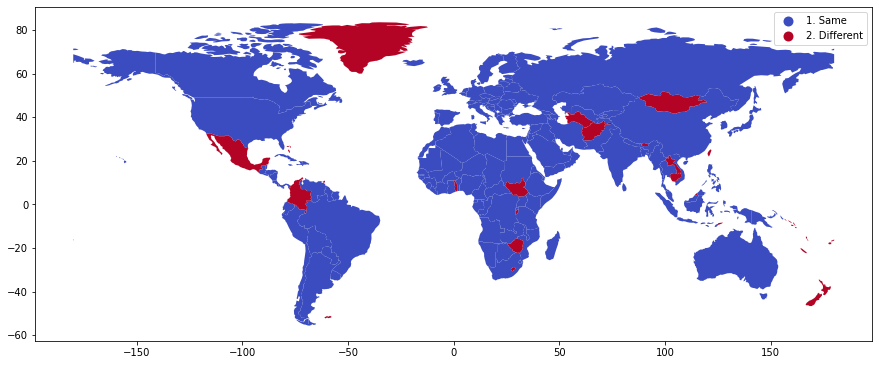

In [ ]:
data_first_period_raw = []

for country in same_trend_first_period:
  data_first_period_raw.append([str(country), "1. Same"])
for country in different_trend_first_period:
  data_first_period_raw.append([str(country), "2. Different"])

data_two_periods = pd.DataFrame(data_first_period_raw, columns= ["Country", "Similarity"])

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = data_two_periods.merge(world, left_on=  "Country", right_on= "iso_a3")
world = geopandas.GeoDataFrame(world)
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['similarity'] = world.Similarity
world.plot(column='similarity', figsize = (15,10), legend=True, cmap='coolwarm')

print("***************************************************************************************************************************")
print("**************************************** SIMILARITY IN TREND OF THE FIRST PERIOD ******************************************")
print("***************************************************************************************************************************")

print("Total: " + str(len(data_countries["iso_code"].unique())))
print() 
print("Same: " + str(len(same_trend_first_period)))
formatted_print(same_trend_first_period)
print("Different: " + str(len(different_trend_first_period)))
formatted_print(different_trend_first_period)

Second period.


***************************************************************************************************************************
**************************************** SIMILARITY IN TREND OF THE SECOND PERIOD *****************************************
***************************************************************************************************************************
Total: 218

Same: 144
Afghanistan, Albania, Andorra, Angola, Argentina, Armenia, Australia, Austria, Azerbaijan, Bahamas, Bahrain,
Bangladesh, Barbados, Belize, Benin, Bolivia, Plurinational State of, Bosnia and Herzegovina, Botswana,
Brazil, Brunei Darussalam, Bulgaria, Burkina Faso, Cabo Verde, Cameroon, Central African Republic, Chad,
Chile, China, Colombia, Comoros, Congo, The Democratic Republic of the, Costa Rica, Croatia,
Cuba, Czechia, Denmark, Djibouti, Dominican Republic, Ecuador, El Salvador, Equatorial Guinea, Eritrea,
Estonia, Eswatini, Ethiopia, Fiji, Finland, Gambia, Germany, Ghana, Greece, Guinea, Guyana,

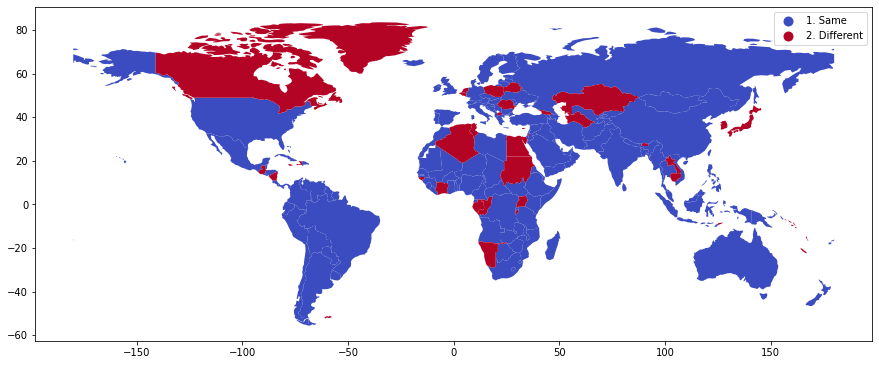

In [ ]:
data_second_period_raw = []

for country in same_trend_second_period:
  data_second_period_raw.append([str(country), "1. Same"])
for country in different_trend_second_period:
  data_second_period_raw.append([str(country), "2. Different"])

data_two_periods = pd.DataFrame(data_second_period_raw, columns= ["Country", "Similarity"])

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = data_two_periods.merge(world, left_on=  "Country", right_on= "iso_a3")
world = geopandas.GeoDataFrame(world)
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['similarity'] = world.Similarity
world.plot(column='similarity', figsize = (15,10), legend=True, cmap='coolwarm')

print("***************************************************************************************************************************")
print("**************************************** SIMILARITY IN TREND OF THE SECOND PERIOD *****************************************")
print("***************************************************************************************************************************")

print("Total: " + str(len(data_countries["iso_code"].unique())))
print() 
print("Same: " + str(len(same_trend_second_period)))
formatted_print(same_trend_second_period)
print("Different: " + str(len(different_trend_second_period)))
formatted_print(different_trend_second_period)

## Distribution of new cases

Finally, we plot the distribution of new confirmed cases in the second phase. We first plot the distribution of countries with a decrease trend in new cases.

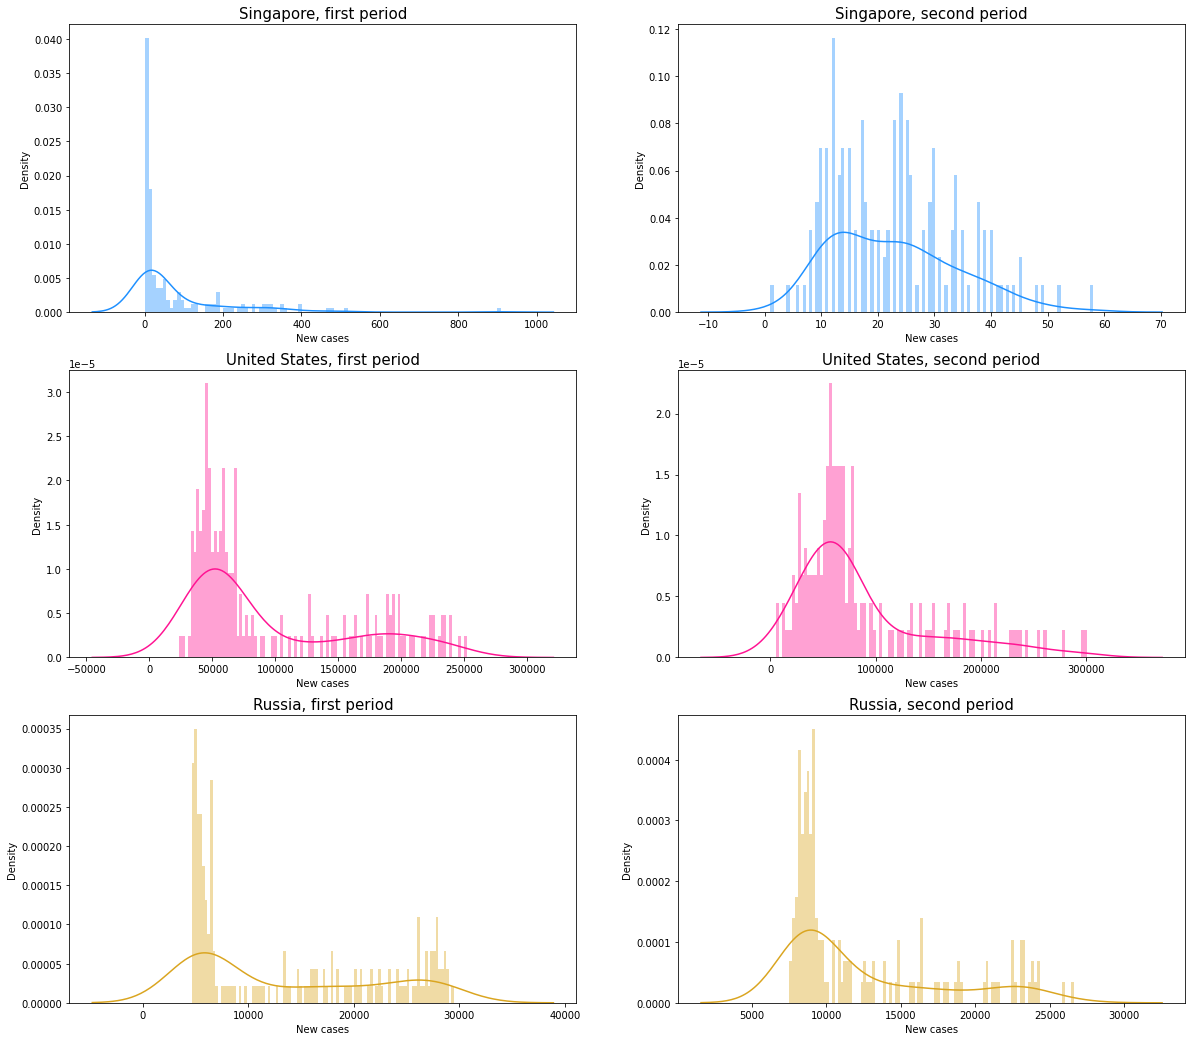

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (20, 18))

colors = ["dodgerblue", "deeppink", "goldenrod", "limegreen"]
inspecting_countries = ["Singapore", "United States", "Russia"]
periods = [[start_date, "2020-12-31"], ["2021-01-01", end_date]]

for row in range(3):
  for col in range(2):
    sns.distplot(data_countries[data_countries["location"] == inspecting_countries[row]]["new_cases"].loc[periods[col][0]:periods[col][1]], color=colors[row], label="Compact", ax=axs[row, col], bins=100)
    axs[row, col].set_title(inspecting_countries[row] + (", first " if col == 0 else ", second ") + "period", fontsize = 15)
    axs[row, col].set(xlabel='New cases')

Then, we plot the distribution of countries with increase in new cases.

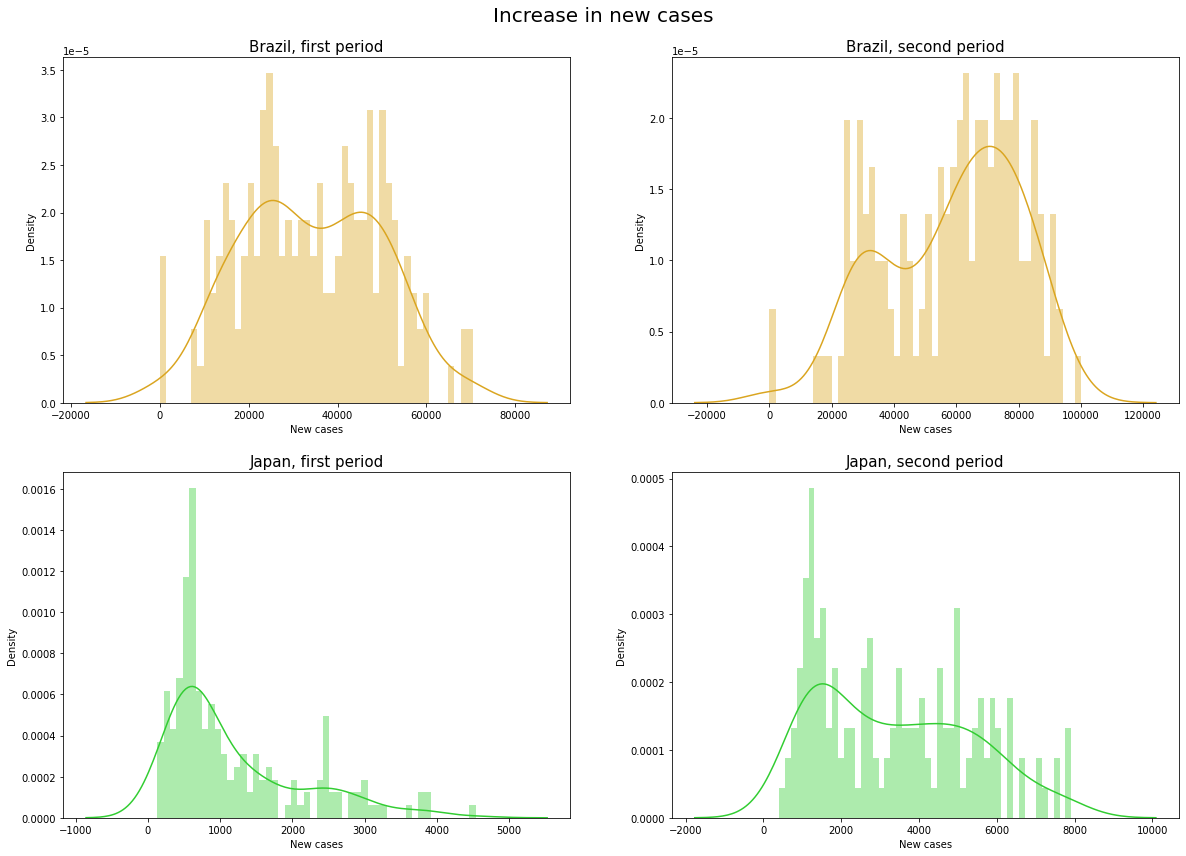

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (20, 14))
fig.suptitle('Increase in new cases', fontsize = 20, y=0.93)

colors = ["goldenrod", "limegreen"]
inspecting_countries = ["Brazil", "Japan"]
periods = [[start_date, "2020-12-31"], ["2021-01-01", end_date]]

for row in range(2):
  for col in range(2):
    sns.distplot(data_countries[data_countries["location"] == inspecting_countries[row]]["new_cases"].loc[periods[col][0]:periods[col][1]],
                  color=colors[row], label="Compact", ax=axs[row, col], bins=50)
    axs[row, col].set_title(inspecting_countries[row] + (", first " if col == 0 else ", second ") + "period", fontsize = 15)
    axs[row, col].set(xlabel='New cases')

 We also plot the distribution of new infections affected by Delta variant

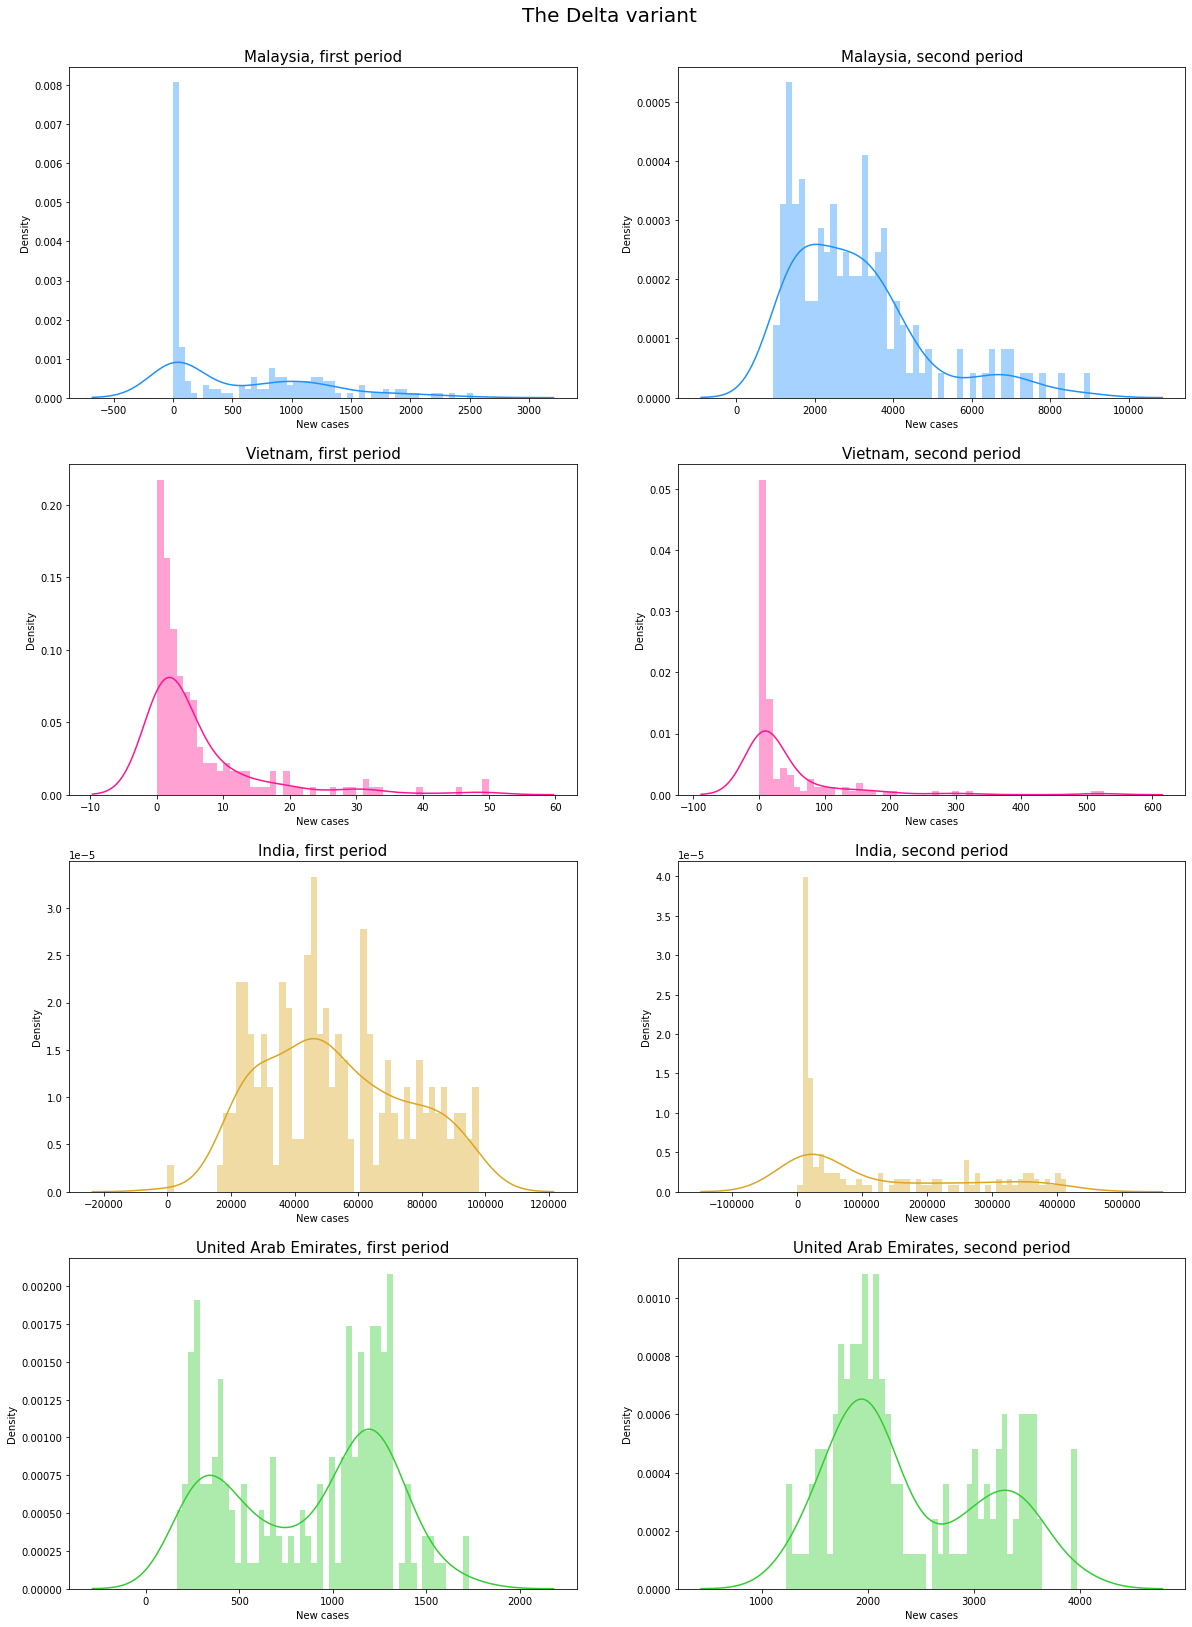

In [ ]:
fig, axs = plt.subplots(4, 2, figsize = (20, 28))
fig.suptitle('The Delta variant', fontsize = 20, y=0.91)

colors = ["dodgerblue", "deeppink", "goldenrod", "limegreen"]
inspecting_countries = ["Malaysia", "Vietnam", "India", "United Arab Emirates"]
periods = [[start_date, "2020-12-31"], ["2021-01-01", end_date]]

for row in range(4):
  for col in range(2):
    sns.distplot(data_countries[data_countries["location"] == inspecting_countries[row]]["new_cases"].loc[periods[col][0]:periods[col][1]],
                  color=colors[row], label="Compact", ax=axs[row, col], bins=50)
    axs[row, col].set_title(inspecting_countries[row] + (", first " if col == 0 else ", second ") + "period", fontsize = 15)
    axs[row, col].set(xlabel='New cases')
